In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import mpltw
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('seaborn')
from Sales_Pipeline import pipeline, user_item_matrix


sales_1 = pd.read_excel('Data\iCheers銷售記錄(2021).xlsx')
sales_2 = pd.read_excel('Data\iCheers銷售記錄(2022).xlsx')
items = pd.read_excel('Data\iCheers酒款資料.xlsx')
grapes = pd.read_excel('Data\iCheers品種.xlsx')
grapes = grapes.groupby('上架編號').agg({'品種': lambda x: '+'.join(list(x))})



sales_1 = pipeline(sales_1, items, grapes)
sales_2 = pipeline(sales_2, items, grapes)
#sales = pd.concat([sales_1, sales_2], axis=0)
sales = sales_2.loc[sales_2['實際銷貨小計']>0]

In [22]:
grapes

,品種
上架編號,
1.0,Pinot Noir
2.0,Malbec
3.0,Pinot Noir
4.0,Savagnin
5.0,Cabernet Sauvignon
...,...
37301.0,Cabernet Franc+Cabernet Sauvignon+Merlot
37302.0,Gamay+Pinot Noir
37303.0,Tempranillo


In [3]:
import math
from scipy.stats import boxcox, yeojohnson
from sklearn.preprocessing import RobustScaler

behaviours = (
    sales.groupby('客戶代碼')
    .agg(訂單數量=('訂單編號','nunique'),
         總瓶數=('銷貨數量','sum'),
         消費總額=('實際銷貨小計','sum'))
)
price = sales.groupby(['客戶代碼', '單價區間'])['銷貨數量'].sum().unstack().fillna(0)
behaviours = pd.concat([behaviours, price], axis=1)
cols = ['訂單數量', '總瓶數', '消費總額',
        '$500以下','$501-1000','$1001-2000',
        '$2001-3000','$3001-4000','$4001-5000',
        '$5001-10000','$10001-20000','$20000以上']
behaviours = behaviours[cols]


behaviours_train = behaviours.copy()

high_train = behaviours_train[behaviours_train['消費總額']>=5e4].index
mid_train = behaviours_train[(behaviours_train['消費總額']<5e4)&(behaviours_train['消費總額']>=2e4)].index
low_train = behaviours_train[behaviours_train['消費總額']<2e4].index

behaviours_train['消費總額'] = np.log(behaviours_train['消費總額'])


behaviours_train = (behaviours_train - behaviours_train.mean())/behaviours_train.std()

# 高階戶分群  

群體標準: 總消費50000以上  
區分標準: $2000以下酒款瓶數占比70%以上 & $4000以上酒款瓶數占比50%以上

In [4]:
behaviours.iloc[:,3:] = behaviours.iloc[:,3:].apply(lambda row: row/row.sum(),axis=1)

In [5]:
high = behaviours[behaviours['消費總額']>=5e4]
#低價酒占比7成以上
low_price = high[high.iloc[:,3:6].sum(axis=1)>=0.7].index
#高價酒占比5成以上
high_price = high[high.iloc[:,8:].sum(axis=1)>=0.5].index
#其餘部分
mid_price = high[~(high.index.isin(set(low_price)|set(high_price)))].index

high.iloc[:,3:-1] = high.iloc[:,3:-1].apply(lambda x: x*high['總瓶數'])

high.loc[high.index.isin(low_price), 'group'] = 0
high.loc[high.index.isin(mid_price), 'group'] = 1
high.loc[high.index.isin(high_price), 'group'] = 2

In [8]:
i=1
high[high['group']==i].describe().drop(columns=['group']).T

,count,mean,std,min,25%,50%,75%,max
訂單數量,352.0,9.542614,7.534037,1.0,5.0,7.0,12.00,5.600000e+01
總瓶數,352.0,54.568182,55.972937,7.0,25.0,38.0,64.00,6.180000e+02
消費總額,352.0,162027.687500,147600.274780,50170.0,72271.5,105783.5,189315.00,1.032581e+06
$500以下,352.0,0.431818,2.604163,0.0,0.0,0.0,0.00,3.300000e+01
$501-1000,352.0,6.028409,10.590502,0.0,0.0,2.0,7.00,1.020000e+02
$1001-2000,352.0,16.002841,21.291693,0.0,5.0,11.0,21.00,2.480000e+02
$2001-3000,352.0,16.309659,21.543255,0.0,6.0,11.0,19.25,2.300000e+02
$3001-4000,352.0,6.281250,9.189235,0.0,1.0,4.0,7.25,9.000000e+01
$4001-5000,352.0,2.656250,4.397424,0.0,0.0,1.0,3.00,3.900000e+01
$5001-10000,352.0,4.678977,6.047939,0.0,0.0,3.0,6.00,3.700000e+01


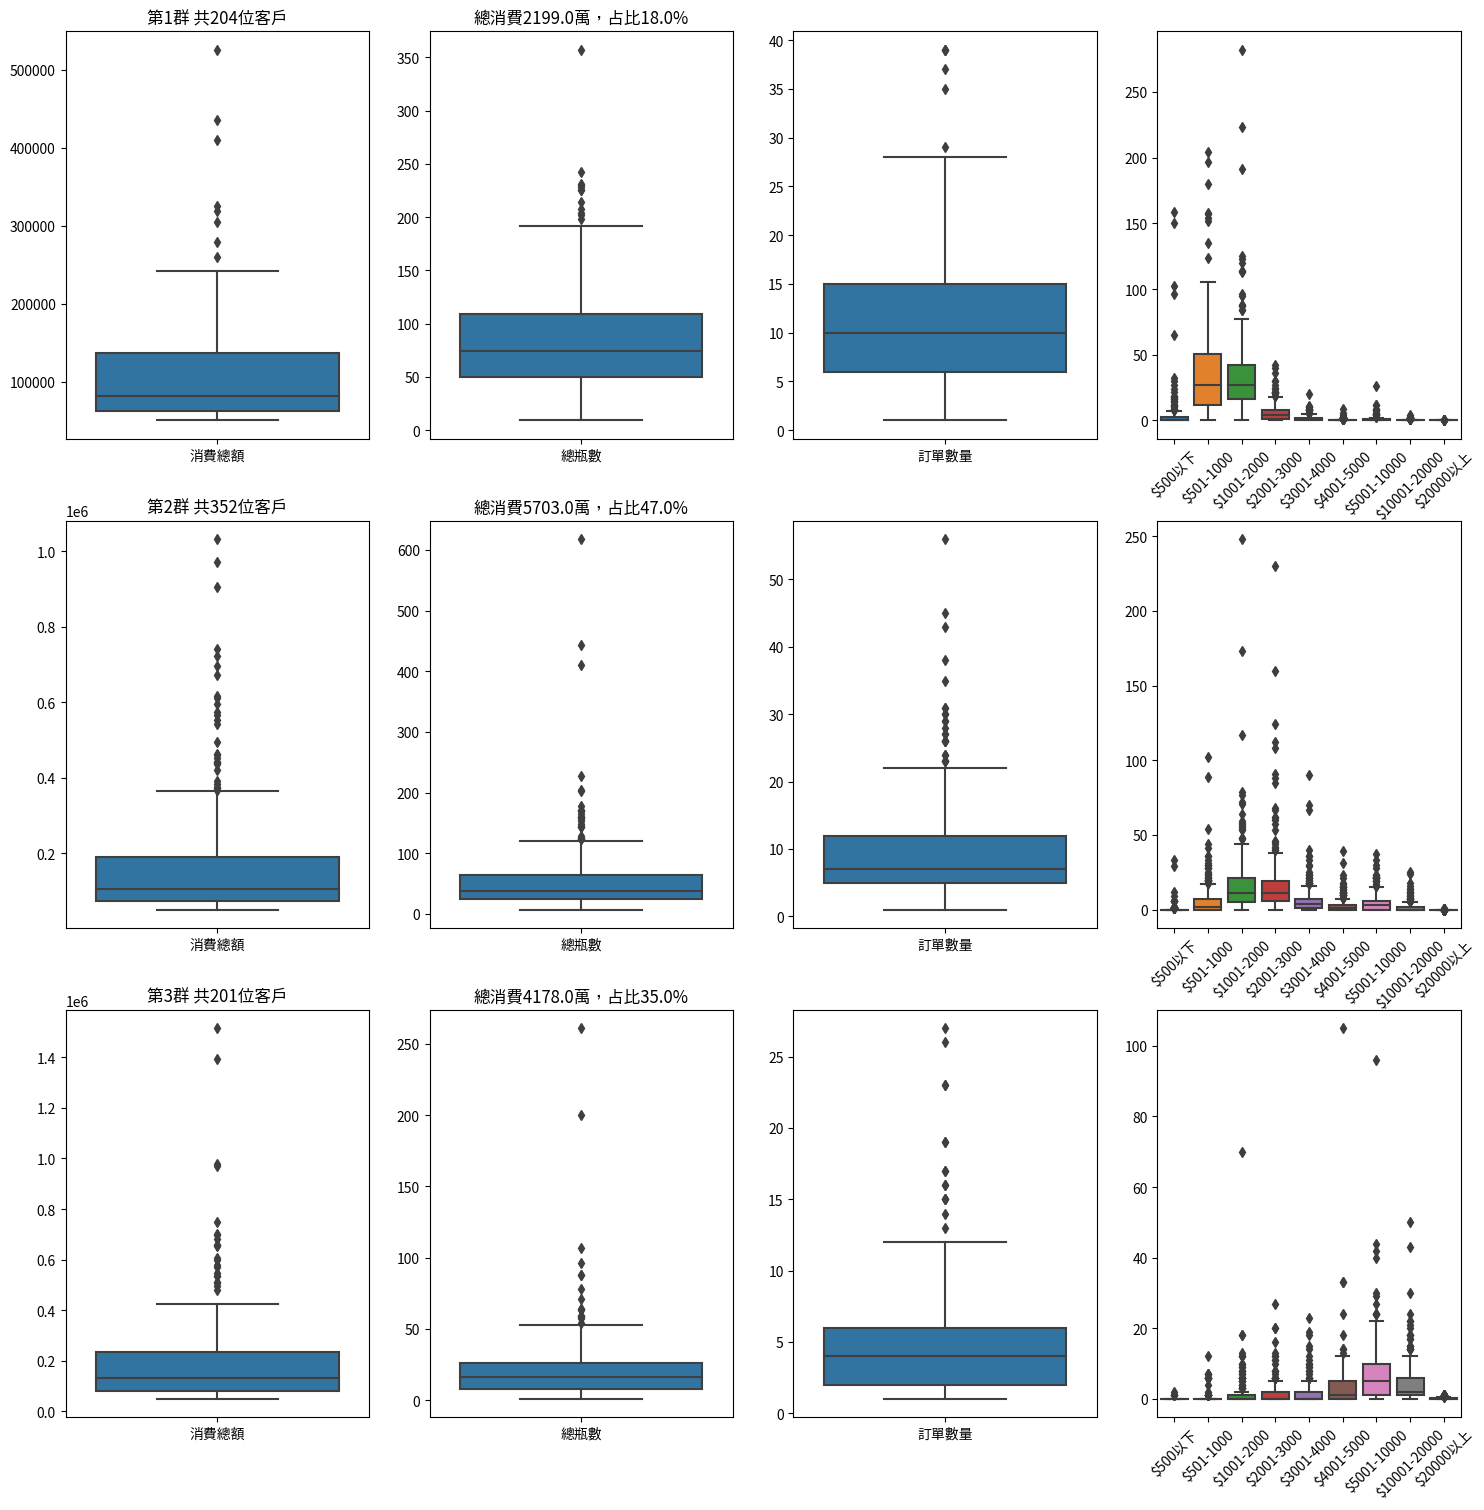

In [7]:
plot_behaviours_boxplots(high, cols, 3)

# 中階戶分群  

群體標準: 總消費20000~50000  
區分標準: $4000以上酒款瓶數占比是否超過25%

In [8]:
mid = behaviours[(behaviours['消費總額']<5e4)&(behaviours['消費總額']>=2e4)]
#高價酒瓶數占比超過25%
mid['group'] = (mid.iloc[:,8:].sum(axis=1)>=0.25).astype(int)
mid.iloc[:,3:-1] = mid.iloc[:,3:-1].apply(lambda x: x*mid['總瓶數'])

In [9]:
i=0
mid[mid['group']==i].describe().drop(columns='group').T

,count,mean,std,min,25%,50%,75%,max
訂單數量,638.0,4.545455,2.790481,1.0,2.0,4.0,6.00,17.0
總瓶數,638.0,22.670846,12.294967,5.0,14.0,20.0,28.00,111.0
消費總額,638.0,31033.990596,8396.047545,20005.0,23812.0,29078.5,37464.75,49940.0
$500以下,638.0,2.043887,8.043911,0.0,0.0,0.0,0.00,103.0
$501-1000,638.0,8.161442,10.460239,0.0,0.0,4.0,12.00,65.0
$1001-2000,638.0,8.266458,6.629545,0.0,3.0,7.0,12.00,42.0
$2001-3000,638.0,2.888715,3.296708,0.0,0.0,2.0,4.75,18.0
$3001-4000,638.0,0.923197,1.813622,0.0,0.0,0.0,1.00,12.0
$4001-5000,638.0,0.152038,0.459083,0.0,0.0,0.0,0.00,5.0
$5001-10000,638.0,0.167712,0.524225,0.0,0.0,0.0,0.00,5.0


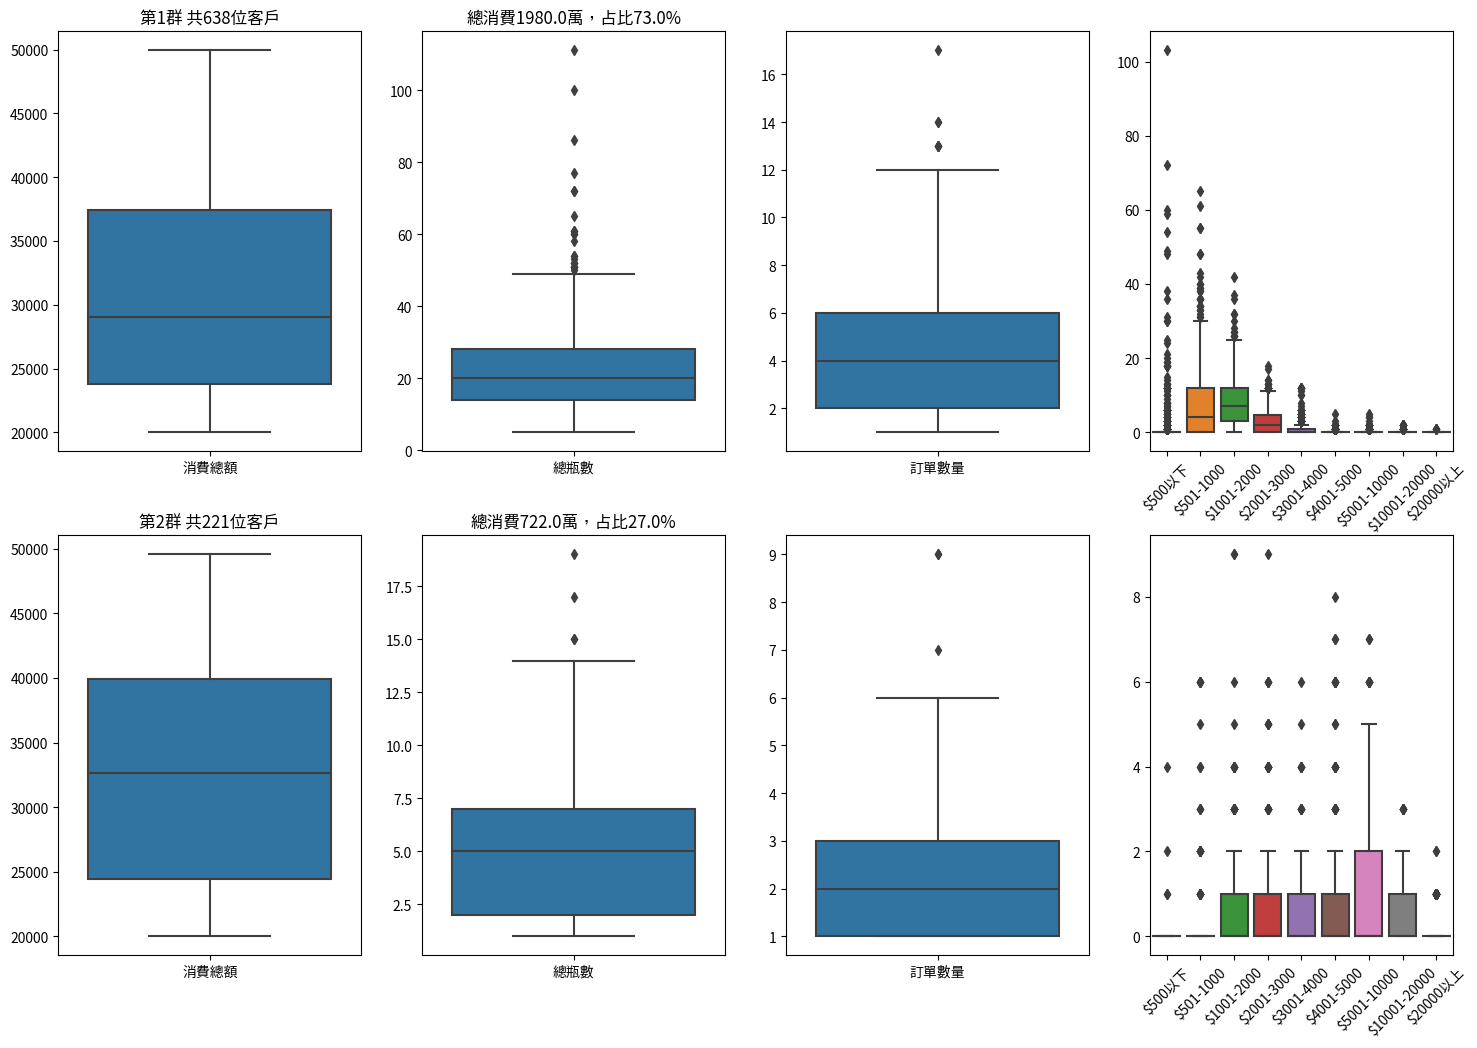

In [10]:
plot_behaviours_boxplots(mid, cols, 2)

# 低階戶分群  

群體標準: 總消費20000以下  
區分標準: 有無買過$2000以上酒款

In [10]:
low = behaviours[behaviours['消費總額']<2e4]
#有無買過$2000以上酒款
low['group'] = ((low.iloc[:,6:].sum(axis=1)!=0)).astype(int)
low.iloc[:,3:-1] = low.iloc[:,3:-1].apply(lambda x: x*low['總瓶數'])

In [13]:
i=1
low[low['group']==i].describe().drop(columns='group').T

,count,mean,std,min,25%,50%,75%,max
訂單數量,1629.0,1.650092,1.082174,1.0,1.0,1.0,2.0,10.0
總瓶數,1629.0,4.437692,4.163941,1.0,1.0,3.0,6.0,35.0
消費總額,1629.0,8854.519337,5072.720765,1730.0,4400.0,7680.0,12921.0,19963.0
$500以下,1629.0,0.241252,1.475889,0.0,0.0,0.0,0.0,24.0
$501-1000,1629.0,1.071823,2.514161,0.0,0.0,0.0,1.0,21.0
$1001-2000,1629.0,1.201351,2.066160,0.0,0.0,0.0,2.0,22.0
$2001-3000,1629.0,1.182934,1.393537,0.0,0.0,1.0,2.0,10.0
$3001-4000,1629.0,0.391037,0.761444,0.0,0.0,0.0,1.0,6.0
$4001-5000,1629.0,0.140577,0.456194,0.0,0.0,0.0,0.0,4.0
$5001-10000,1629.0,0.171271,0.452413,0.0,0.0,0.0,0.0,3.0


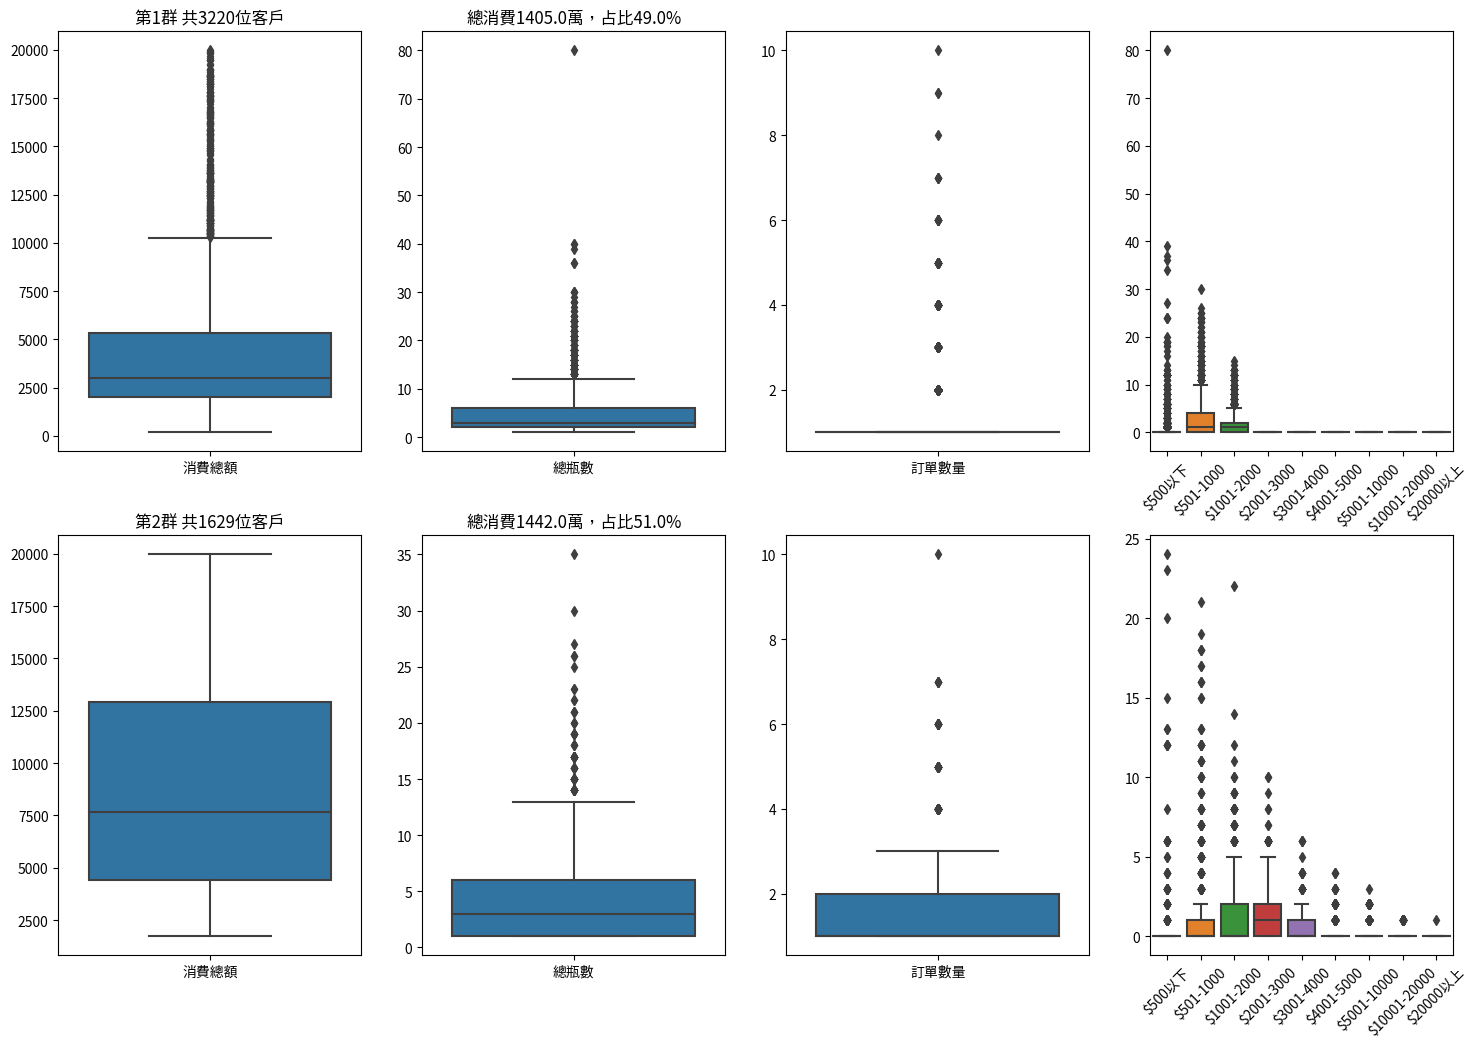

In [13]:
plot_behaviours_boxplots(low, cols, 2)